In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(0)

In [2]:
log    = lambda x: np.log(x)
loglog = lambda x: np.log(np.log(x))

In [3]:
def confident_interval_indices(vector, confidence_level=0.50):
    mean = np.mean(vector)
    std_dev = np.std(vector)
    margin_error = std_dev * norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound = mean - margin_error
    upper_bound = mean + margin_error
    indices = np.where((vector >= lower_bound) & (vector <= upper_bound))[0]

    return indices

In [4]:
# Set global font size
plt.rcParams.update({'font.size': 15})

def plot_feature_target(dataset_name, feature_name, feature_engineer, feature_engineer_name, ax):
    features_df = pd.read_csv('../training_data/' + dataset_name + '/inputs.csv').sort_values(by='sequenceID')
    targets_df  = pd.read_csv('../training_data/' + dataset_name + '/outputs.csv').sort_values(by='sequenceID')

    feature = features_df[feature_name].to_numpy()
    feature = feature_engineer(feature)
    small_target = targets_df['min.log.lambda'].to_numpy()
    big_target   = targets_df['max.log.lambda'].to_numpy()

    # filter
    sampled_indices = confident_interval_indices(feature, confidence_level=0.9)
    sampled_indices = np.random.choice(sampled_indices, 100, replace=False)
    feature = feature[sampled_indices]
    small_target = small_target[sampled_indices]
    big_target = big_target[sampled_indices]

    # Plotting
    ax.scatter(feature, small_target, label='lower limit', color='black', marker='o', facecolors='none', edgecolors='black', s=60)
    ax.scatter(feature, big_target, label='upper limit', color='black', marker='o', s=60)

    ax.set_xlabel("feature = " + feature_engineer_name + " " + feature_name)

In [5]:
def plot_row(dataset_name, feature_names, axs):
    legend_handles = []
    legend_labels = []
    for i, feature_name in enumerate(feature_names):
        if (feature_name in ['variance', 'range_value']):
            feature_engineer = log
            feature_engineer_name = 'log'
        else:
            feature_engineer = loglog
            feature_engineer_name = 'loglog'
        plot_feature_target(dataset_name, feature_name, feature_engineer, feature_engineer_name, axs[i])
        # Set y-label only for the first subplot in each row
        if i == 0:
            axs[i].set_ylabel('output = optimal ' + r'$\log\lambda$')
        # Collect handles and labels for each subplot
        h, l = axs[i].get_legend_handles_labels()
        # Only add unique handles and labels to the list
        for handle, label in zip(h, l):
            if label not in legend_labels:
                legend_handles.append(handle)
                legend_labels.append(label)

    return legend_handles, legend_labels

def plot_features_targets(dataset_name):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    feature_names = ['variance', 'length', 'range_value', 'sum_diff']
    legend_handles = []
    legend_labels = []
    for i in range(0, len(feature_names), len(axs)):
        handles, labels = plot_row(dataset_name, feature_names[i:i+len(axs)], axs)
        legend_handles.extend(handles)
        legend_labels.extend(labels)

    # Create a combined legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper left')
    plt.tight_layout()
    plt.savefig('features_targets_' + dataset_name +'.pdf')
    plt.savefig('features_targets_' + dataset_name +'.jpg')

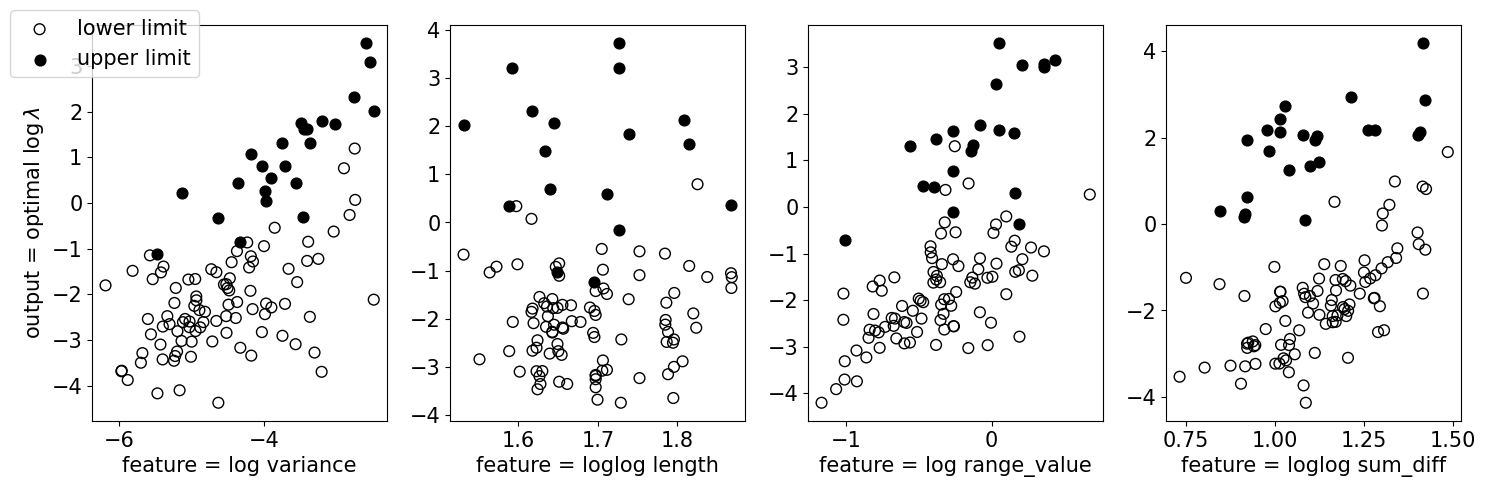

In [6]:
plot_features_targets('detailed')

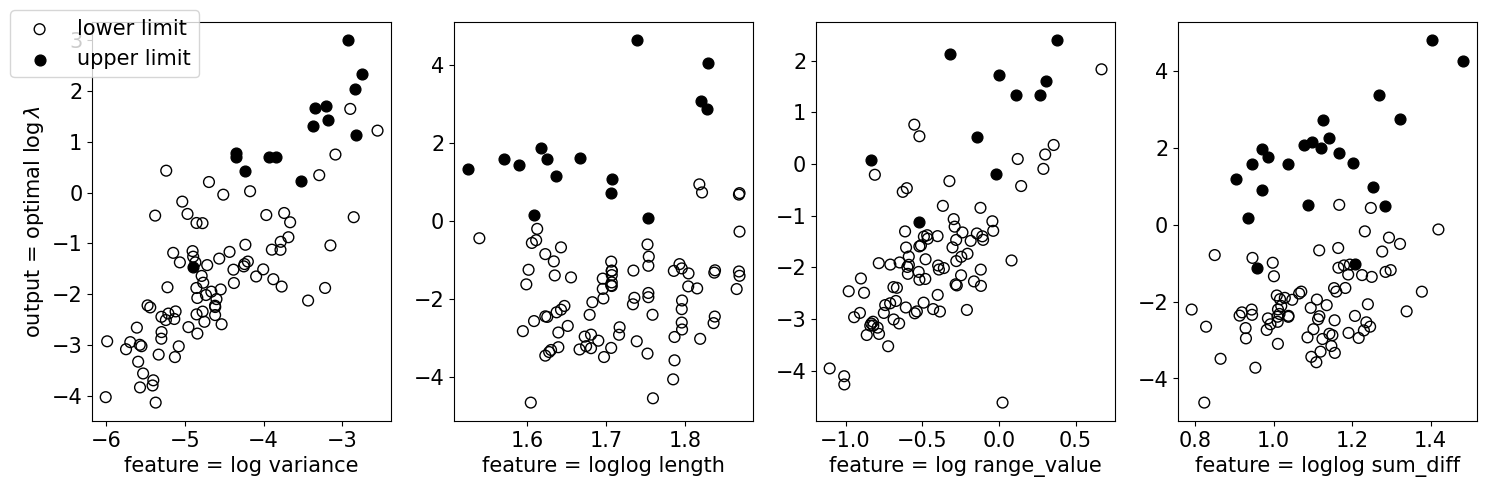

In [7]:
plot_features_targets('systematic')

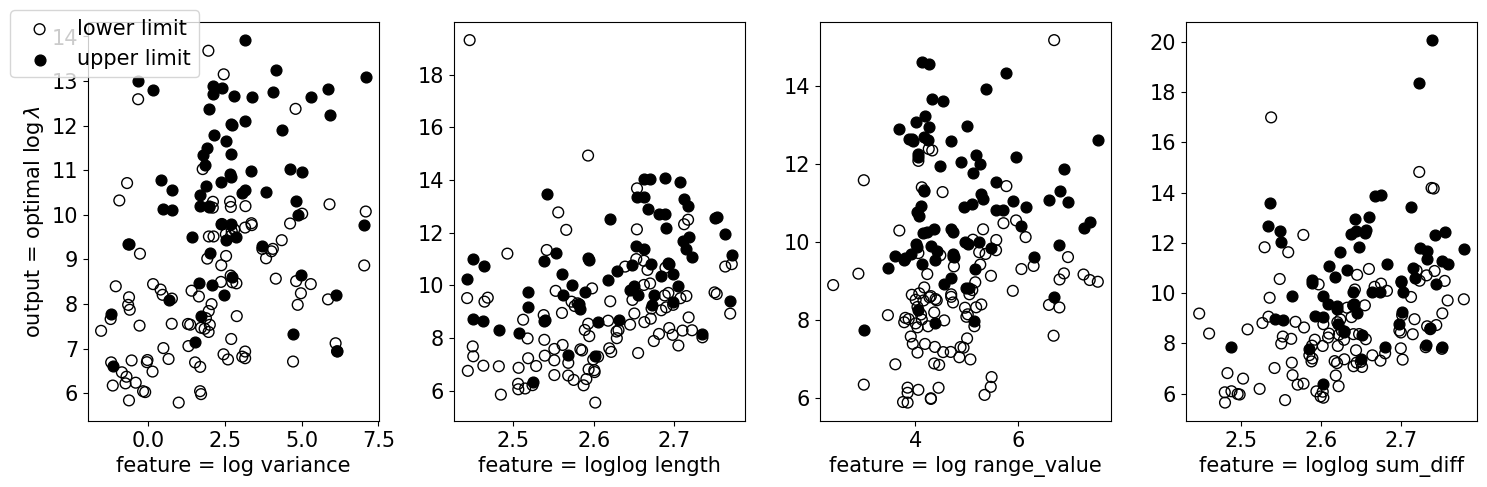

In [8]:
plot_features_targets('epigenomic')

In [9]:
def plot_row(dataset_name, feature_names, axs, is_last_dataset):
    legend_handles = []
    legend_labels = []
    for i, feature_name in enumerate(feature_names):
        if (feature_name in ['variance', 'range_value']):
            feature_engineer = log
            feature_engineer_name = 'log'
        else:
            feature_engineer = loglog
            feature_engineer_name = 'loglog'
        plot_feature_target(dataset_name, feature_name, feature_engineer, feature_engineer_name, axs[i])
        # Set y-label only for the first subplot in each row
        if i == 0:
            axs[i].set_ylabel('output = optimal ' + r'$\log\lambda$')
        # Remove x-label from all subplots except the last row
        if not is_last_dataset:
            axs[i].set_xlabel('')
        else:
            axs[i].set_xlabel("feature = " + feature_engineer_name + " " + feature_name)
        # Add dataset name to the far right of the y-axis in the last column
        if i == len(feature_names) - 1:
            axs[i].text(1.1, 0.5, "dataset: " + dataset_name, transform=axs[i].transAxes, va='center', ha='left', rotation=-90)
        # Collect handles and labels for each subplot
        h, l = axs[i].get_legend_handles_labels()
        # Only add unique handles and labels to the list
        for handle, label in zip(h, l):
            if label not in legend_labels:
                legend_handles.append(handle)
                legend_labels.append(label)

    return legend_handles, legend_labels

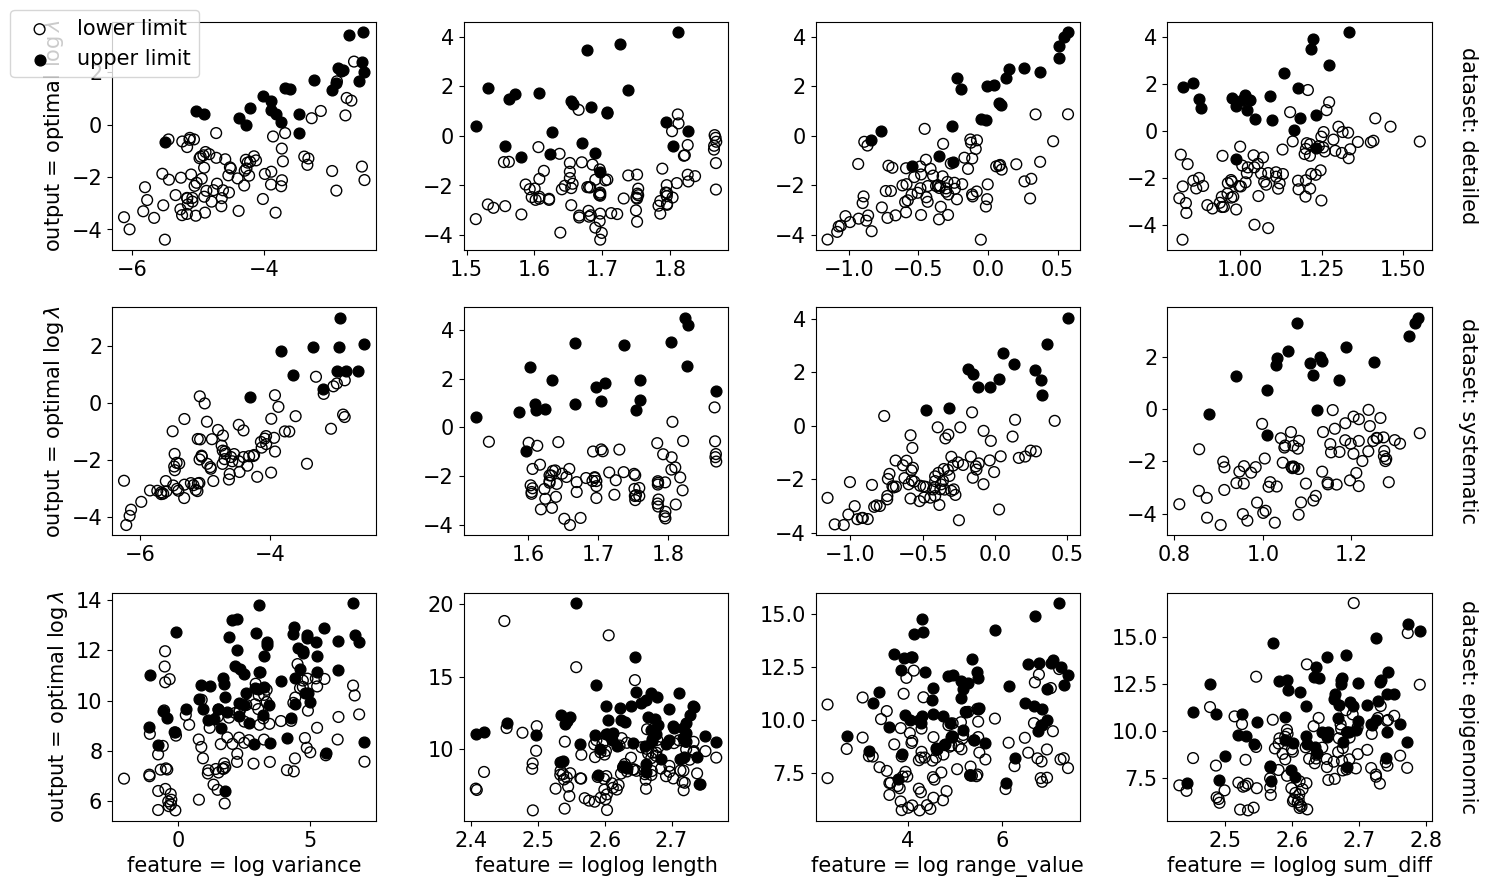

In [11]:
def plot_all_datasets():
    datasets = ['detailed', 'systematic', 'epigenomic']
    
    fig, axs = plt.subplots(3, 4, figsize=(15, 9))  # Three rows for three datasets
    
    legend_handles = []
    legend_labels = []
    
    for dataset_idx, dataset_name in enumerate(datasets):
        feature_names = ['variance', 'length', 'range_value', 'sum_diff']
        is_last_dataset = (dataset_idx == len(datasets) - 1)  # True for the last dataset, False otherwise
        
        for i in range(0, len(feature_names), len(axs[0])):
            handles, labels = plot_row(dataset_name, feature_names[i:i+len(axs[0])], axs[dataset_idx], is_last_dataset)
            legend_handles.extend(handles)
            if dataset_idx == 0:  # Only add labels once
                legend_labels.extend(labels)

    # Create a single legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper left')
    plt.tight_layout()
    plt.savefig('features_targets_all_datasets.pdf')
    plt.savefig('features_targets_all_datasets.jpg')

plot_all_datasets()